In [1]:
import coolingFunction

In [2]:
import copy
import numpy as np
import h5py
import scipy
import scipy.special
import sys
import verdict
import os
import tqdm
import unyt

In [3]:
import kalepy as kale

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
import matplotlib.cm as cm
import matplotlib.colors as plt_colors
import matplotlib.gridspec as gridspec
import matplotlib.transforms
import palettable

In [5]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.worldline_set as worldline_set
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [6]:
import galaxy_dive.analyze_data.ahf as analyze_ahf
import galaxy_dive.plot_data.ahf as plot_ahf
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.utils.executable_helpers as exec_helpers

In [7]:
import linefinder.utils.file_management as file_management
import linefinder.config as config

In [8]:
import trove

In [9]:
from py2tex import py2tex

In [10]:
import helpers

In [11]:
%matplotlib inline

# Load Data

In [12]:
pm = dict(
    snum = 600,
    tables_dir = '/work/03057/zhafen/CoolingTables/',
    study_duplicates = False,
    ahf_index = 600,
    
    # For the fancy scatter plot we're visualizing.
    variable_alpha = True,
)

In [13]:
pm = trove.link_params_to_config(
    '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
    script_id = 'nb.11',
    variation = 'm12i_md',
    global_variation = '',
    **pm
)

In [14]:
# Used so often it's nice to not enclose
snum = pm['snum']
ind = pm['ahf_index'] - snum

In [15]:
w = a_worldlines.Worldlines(
    tag = pm['tag'],
    data_dir = pm['base_data_dir'],
    halo_data_dir = pm['halo_data_dir'],
    ahf_index = pm['ahf_index'],
)

In [16]:
w.retrieve_halo_data()

/home1/03057/zhafen/repos/galaxy-dive/galaxy_dive/analyze_data/simulation_data.py:1181: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.halo_coords = halo_coords_comoving * scale_factor_and_hinv[np.newaxis, :]


In [17]:
m_plot_label  = r'$M_{\rm h} = 10^{' + '{:.02g}'.format( np.log10( w.m_vir[snum] ) )
m_plot_label += '} M_\odot$'
plot_label = m_plot_label + ', z={:.02}'.format( w.redshift[snum] )
print( plot_label )

$M_{\rm h} = 10^{12} M_\odot$, z=0.0


In [18]:
base_processed_data_dir = pm['config_parser'].get( 'DEFAULT', 'processed_data_dir' )
default_data_fp = os.path.join( base_processed_data_dir, 'summary.hdf5' )
default_data = verdict.Dict.from_hdf5( default_data_fp, create_nonexistent=True )

/home1/03057/zhafen/repos/verdict/verdict.py:1403: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if hasattr( a[first_element_index][0], 'decode' ):


In [19]:
data_fp = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )
data = verdict.Dict.from_hdf5( data_fp, create_nonexistent=True )

In [20]:
if pm['plt_style'] is not None:
    plt.style.use( pm['plt_style'] )

## Labels

In [21]:
tchange_key = pm['central_indices'].split( '_' )[0]
t_tchange_key = 't_' + tchange_key

In [22]:
t_tchange_label = helpers.get_t_tchange_label( pm )

## Calculate Central Indices

In [23]:
if pm['central_indices'] == 'tcools_inds':
    inds = w.calc_tcools_inds(
        lookback_time_max = pm['lookback_time_max'],
        choose_first = pm['choose_first'],
        B = pm['logTcools'],
    )
else:
    calc_fn = getattr( w, 'calc_{}'.format( pm['central_indices'] ) )
    inds = calc_fn(
        lookback_time_max = pm['lookback_time_max'],
        choose_first = pm['choose_first'],
    )

100%|██████████| 45846/45846 [00:02<00:00, 16744.09it/s]


In [24]:
# valid = inds > pm['minInd']
valid = inds != config.INT_FILL_VALUE
valid_inds = inds[valid]
particle_inds = np.arange( w.n_particles )[valid]

## Calculate $\vec j$

In [25]:
specific_mom = w.get_data( 'J' )
w.data['Jmag'] = w.get_data( 'Jmag' )

In [26]:
tot_momentum_fp = os.path.join( base_processed_data_dir, 'tot_momentums.hdf5' )
tot_ang_momentum = verdict.Dict.from_hdf5( tot_momentum_fp )[pm['variation']]['snum{:03d}'.format( snum )]

In [27]:
tot_ang_momentum_normed = tot_ang_momentum / np.linalg.norm( tot_ang_momentum )
_ = w.calc_ang_momentum_alignment( tot_ang_momentum_normed )

/home1/03057/zhafen/repos/galaxy-dive/galaxy_dive/analyze_data/simulation_data.py:1472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if normal_vector == 'total ang momentum':


In [28]:
# Setup coordinate system
z_hat = tot_ang_momentum_normed
x_hat = np.cross( z_hat, np.array([ 0., 1., 0. ]) )
x_hat /= np.linalg.norm( x_hat )
y_hat = np.cross( z_hat, x_hat )

In [29]:
# Calculate on-sky coordinates
theta = []
phi = []
for i, jmag_i in enumerate( tqdm.tqdm( w.get_data( 'Jmag' ).transpose() ) ):

    # Calculate angular momentum components
    j_i = w.get_data( 'J' )[:,:,i].transpose()
    jz_i = w.get_data( 'Jz' )[:,i]
    jperp_i = j_i - z_hat * jz_i[:,np.newaxis]
    jx_i = np.dot( x_hat, jperp_i.transpose() )
    jy_i = np.dot( y_hat, jperp_i.transpose() )

    # Theta and phi
    theta_i = np.arccos( jz_i / jmag_i )
    phi_i = np.arctan2( jy_i, jx_i )
    
    theta.append( theta_i )
    phi.append( phi_i )
    
w.data['ThetaJ'] = np.array( theta ).transpose()
w.data['PhiJ'] = np.array( phi ).transpose()

100%|██████████| 601/601 [00:03<00:00, 187.16it/s]


# Plot

## Settings

In [30]:
def get_cmap_and_norm( data_key ):

    if data_key == 'T':
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'berlin_white',
            [
                palettable.scientific.diverging.Berlin_3.mpl_colors[0],
                'w',
                palettable.scientific.diverging.Berlin_3.mpl_colors[-1],
            ],
        )
        norm = plt_colors.LogNorm( vmin=1e4, vmax=1e6 )
    elif data_key == 'Jz/Jmag':
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'tofino_white',
            [
                palettable.cartocolors.diverging.Tropic_7.mpl_colors[-2],
                'w',
                palettable.cartocolors.diverging.Tropic_7.mpl_colors[1],
            ],
        )
        norm = plt_colors.Normalize( vmin=-1, vmax=1 )

    return cmap, norm

In [31]:
cmap, norm = get_cmap_and_norm( 'T' )

In [32]:
# Setup time steps
delta_t = 0.01
t_movie_after = np.arange( 0., 0.5 + delta_t, delta_t )
t_movie_before = -1. * np.arange( 0., 1.5 + delta_t, delta_t )[1:][::-1]
t_movie = np.concatenate( [ t_movie_before, t_movie_after ]  )

## Get Time Offset
Find offset for each worldline (to account for t_tchange occuring between snapshots)

In [33]:
# Mask Data
w.data_masker.clear_masks()
w.data_masker.mask_data( 'n_out', -1, 1 ) # Only include particles that have never left the main galaxy
w.data_masker.mask_data( 'PType', data_value=0 )

In [34]:
# Find particles that are valid near tchange
mask_overall = w.data_masker.get_mask()
mask_at_tchange = mask_overall[particle_inds,valid_inds]
mask_after_tchange = mask_overall[particle_inds,valid_inds-1]
masked_near_tchange = np.logical_and( mask_at_tchange, mask_after_tchange )
valid_near_tchange = np.invert( masked_near_tchange )

In [35]:
# Find the temperatures to interpolate to get the offset
T_at_tchange = w.get_data( 'T' )[particle_inds,valid_inds][valid_near_tchange]
T_after_tchange = w.get_data( 'T' )[particle_inds,valid_inds-1][valid_near_tchange]
logT_interp = np.log10( np.array([ T_at_tchange, T_after_tchange ]).transpose() )

In [36]:
# Find the times to interpolate to get the offset
t_tchange = w.get_data( t_tchange_key )
t_tchange_at_tchange = t_tchange[particle_inds,valid_inds][valid_near_tchange]
t_tchange_after_tchange = t_tchange[particle_inds,valid_inds-1][valid_near_tchange]
t_tchange_interp = np.array([ t_tchange_at_tchange, t_tchange_after_tchange ]).transpose()
t_tchange = w.get_data( t_tchange_key )[particle_inds]

In [37]:
if pm['central_indices'] == 'tcools_inds':
    # Get the offset
    time_offsets = []
    n_wrong = 0
    for i, tchange_interp_i in enumerate( tqdm.tqdm( t_tchange_interp ) ):
        interp_fn = scipy.interpolate.interp1d( logT_interp[i], t_tchange_interp[i],  )
        try:
            time_offsets.append( interp_fn( pm['logTcools'] ) )
        except ValueError:
            time_offsets.append( np.nan )
            n_wrong += 1

    time_offsets = np.array( time_offsets )
    print( n_wrong, n_wrong / t_tchange_interp.shape[0] )

    time_offsets_all = np.full( particle_inds.size, np.nan )
    time_offsets_all[valid_near_tchange] = time_offsets

    t_tchange_corrected = t_tchange - time_offsets_all[:,np.newaxis]

    # The below code shows individual cases where tchange appears to be calculated wrong
    if np.isnan( time_offsets ).sum() > 0:
        i = np.argmax( time_offsets )
        weird_original_ind = particle_inds[valid_near_tchange][i]
        print( np.log10( w.get_data( 'T' )[weird_original_ind] )[inds[weird_original_ind]-2:inds[weird_original_ind]+1] )
else:
    t_tchange_corrected = t_tchange

100%|██████████| 31064/31064 [00:02<00:00, 11654.12it/s]


233 0.007500643832088591
[2.3134534 6.06984   6.32918  ]


## Get Data

In [38]:
w.data_masker.clear_masks()
w.data_masker.mask_data( 'n_out', -1, 1 ) # Only include particles that have never left the main galaxy
w.data_masker.mask_data( 'PType', data_value=0 )

In [39]:
ds = []
for i, t_frame in enumerate( tqdm.tqdm( t_movie ) ):

    t_frame_inds = np.argmin( np.abs( t_tchange_corrected - t_frame ), axis=1 )

    # Prepare to mask
    if len( w.data_masker.masks ) == 3:
        del w.data_masker.masks[2]

    # Mask data that's out of bounds
    out_of_bounds = t_frame_inds <= 0
    out_of_bounds_full = np.zeros( w.n_particles ).astype( 'bool' )
    out_of_bounds_full[particle_inds] = out_of_bounds
    out_of_bounds_mask = np.tile( out_of_bounds_full, ( w.n_snaps, 1 ) ).transpose()
    w.data_masker.mask_data( 'out_of_bounds', custom_mask=out_of_bounds_mask,  )

    # Base parameters
    d = {}
    for key in [ 'Rx', 'Ry', 'Rz', 'M', 'Den', 'T', 'Jz/Jmag', 'ThetaJ', 'PhiJ' ]:
        d[key] = w.get_selected_data( key, compress=False )[particle_inds,t_frame_inds].compressed()

    # Volume and smoothing length
    den_msunkpc3 = ( d['Den']*unyt.mp/unyt.cm**3  ).to( 'Msun/kpc**3' )
    d['Vol'] = d['M'] * unyt.Msun / den_msunkpc3
    d['h'] = ( 3. * d['Vol'] / 4. / np.pi )**(1./3.)

    ds.append( d )

100%|██████████| 201/201 [05:17<00:00,  1.58s/it]


## Make Frames

In [40]:
# Frame and scalebar size objects
def round_down(num, divisor):
    return num - (num%divisor)

In [41]:
# The t_movie cut is set to be useless by default.
lim = np.max( [ np.nanpercentile( np.abs( ds[i]['Rx'] ), 95 ) for i in np.arange(len(ds))[(t_movie >= -0.5)&(t_movie <=0.2)] ] )

In [42]:
for data_key in [ 'Jz/Jmag', 'T' ]:

    cmap, norm = get_cmap_and_norm( data_key )

    i_focused = 0

    for i, d in enumerate( tqdm.tqdm( ds ) ):
        
        # DEBUG
        if i not in [ 150, ]:
            continue

        fig = plt.figure( figsize=(12,10), facecolor='k' )
        ax = plt.gca()

        # Point size
        if len( d['M'] ) > 0:
            width_in_data = 2 * lim
            width_in_pixels = ax.get_window_extent().width
            pixels_to_points = fig.dpi / 72.
            scale = 10.
            radius = d['h'] * ( width_in_pixels / width_in_data ) * pixels_to_points * scale
            s = ( radius )**2.

            # Colors
            colors = cmap( norm( d[data_key] ) )

            # Alpha
            if pm['variable_alpha']:
                column_den = d['M'] / d['h']**2.
                alpha = plt_colors.LogNorm( vmin=np.nanmin( column_den ), vmax=np.nanmax( column_den ) )( column_den ) * 0.065 * ( 50000 / w.n_particles)
                alpha[alpha>1.] = 1.
                alpha[alpha<0.] = 0.
                colors[:,3] = alpha
            else:
                colors[:,3] = 0.01

            # Plot itself
            ax.scatter(
                d['Rx'],
                d['Rz'],
                s = s,
                c = colors,
                edgecolors = 'none',
            )

        # Scale bar
        size = round_down( min( 30., 0.95 * lim ), 10 )
        if np.isclose( size, 0. ):
            size = 10.
        xy = ( -size, -0.95*lim )
        line = ax.plot(
            xy[0] + np.array([ 0., size ]),
            [ xy[1], xy[1] ],
            linewidth = 10,
            color = 'w',
            path_effects = [
                path_effects.Stroke(linewidth=12, foreground='black'),
                path_effects.Normal()
            ]
        )
        text = ax.annotate(
            text = '{:.2g} kpc'.format( size ),
            xy = xy,
            xycoords = 'data',
            xytext = ( 5, 10 ),
            textcoords = 'offset points',
            va = 'bottom',
            ha = 'left',
            color = 'w',
            fontsize = 42,
        )
        text.set_path_effects([
            path_effects.Stroke(linewidth=2.5, foreground='black'),
            path_effects.Normal()
        ])

        # Plot label
        annotate_label = (
            r'$t - ' +
            helpers.get_tchange_label( pm )[1:] +
            '= {} Myrs'.format( int( t_movie[i]*1e3 ) )
        )
        text = ax.annotate(
            text = annotate_label,
            xy = ( 1, 1 ),
            xycoords = 'axes fraction',
            xytext = ( -10, -10 ),
            textcoords = 'offset points',
            va = 'top',
            ha = 'right',
            color = 'w',
            fontsize = 42,
        )
        text.set_path_effects([
            path_effects.Stroke(linewidth=2.5, foreground='black'),
            path_effects.Normal()
        ])
        
        # Temperature
        if len( d['T'] ) > 0:
            temp_label = r'$\langle \log (T/{\rm K}) \rangle =' + py2tex.to_tex_scientific_notation( np.nanmedian( np.log10( d['T'] ) ), sig_figs=2 ) + r'$'
            text = ax.annotate(
                text = temp_label,
                xy = ( 1, 0 ),
                xycoords = 'axes fraction',
                xytext = ( -10, 10 ),
                textcoords = 'offset points',
                va = 'bottom',
                ha = 'right',
                color = 'w',
                fontsize = 34,
            )
            text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])

        # Limits
        ax.set_xlim( -lim, lim )
        ax.set_ylim( -lim, lim )
        ax.set_aspect( 'equal' )

        # Ticks
        plt.tick_params(
            which = 'both',
            left = False,
            labelleft = False,
            bottom = False,
            labelbottom = False,
        )

        # Change colors
        ax.set_facecolor( 'k' )
        plt.setp( ax.spines.values(), color='w' )
        [m.set_linewidth(3) for m in ax.spines.values()]

        save_file_tag = {
            'T': '',
            'Jz/Jmag': '_alignment',
        }[data_key]
        plotting.save_fig(
            out_dir = os.path.join( pm['data_dir'], 'projected_frames' ),
            save_file = '{}{}_{:0>3d}.png'.format( pm['variation'], save_file_tag, i ),
            fig = fig,
            resolution = 150.,
        )

        # Save movie focused on time of cooling or accreting
        if np.abs( t_movie[i] ) <= 0.150:
            plotting.save_fig(
                out_dir = os.path.join( pm['data_dir'], 'projected_frames' ),
                save_file = '{}{}_focused_{:0>3d}.png'.format( pm['variation'], save_file_tag, i_focused ),
                fig = fig,
                resolution = 150.,
            )
            i_focused += 1

        plt.close()

  0%|          | 0/201 [00:00<?, ?it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_alignment_150.png


  0%|          | 0/201 [00:00<?, ?it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_alignment_focused_000.png
File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_150.png


100%|██████████| 201/201 [00:01<00:00, 152.48it/s]

File saved at /scratch/03057/zhafen/hot_accretion_data/m12i_md/projected_frames/m12i_md_focused_000.png


In [59]:
i = 200
d = ds[i]

array([ 0.74700675,  0.20778987,  0.17867654, ..., -0.8004478 ,
        0.87625144,  0.69080513])

In [107]:
n_sample = 1000000
test_data = np.random.randn( n_sample, 3 )
test_data /= np.linalg.norm( test_data, axis=1 )[:,np.newaxis]
theta = np.arccos( test_data[:,-1] )
phi = np.arctan2( test_data[:,1], test_data[:,0] )

In [108]:
import cartopy.crs as ccrs

In [109]:
regular_proj = ccrs.PlateCarree()
rotated_proj = ccrs.RotatedPole(pole_longitude=0., pole_latitude=0.)

In [127]:
projections = [
    ( 'Geostationary', rotated_proj ),
    ( 'LambertAzimuthalEqualArea', rotated_proj ),
    ( 'AlbersEqualArea', regular_proj ),
    ( 'AzimuthalEquidistant', rotated_proj ),
    ( 'LambertConformal', regular_proj ),
    ( 'Sinusoidal', regular_proj ),
    ( 'Mollweide', rotated_proj ),
]

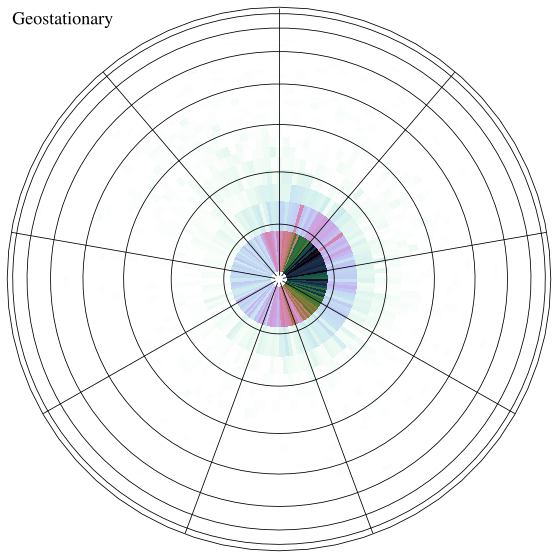

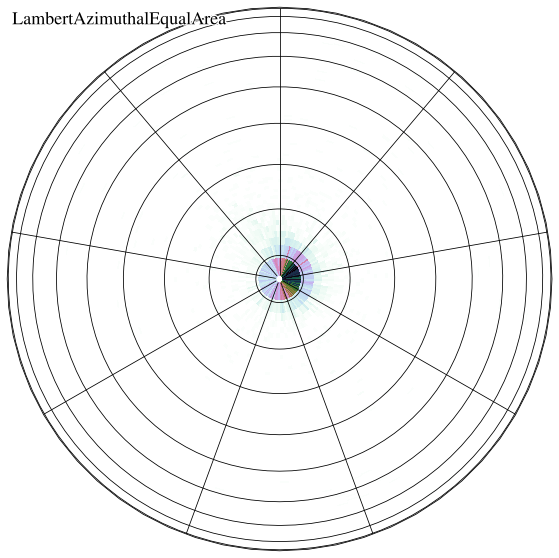

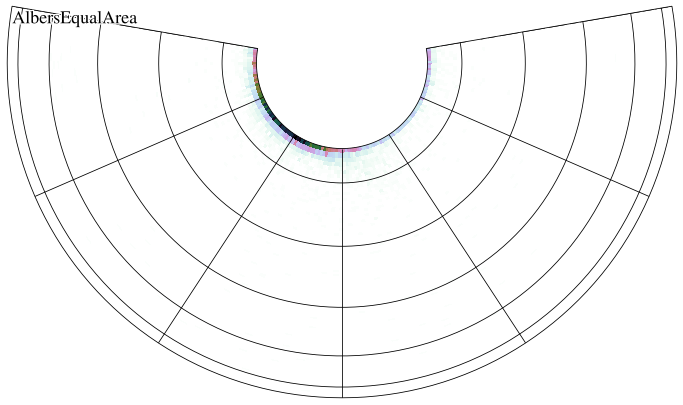

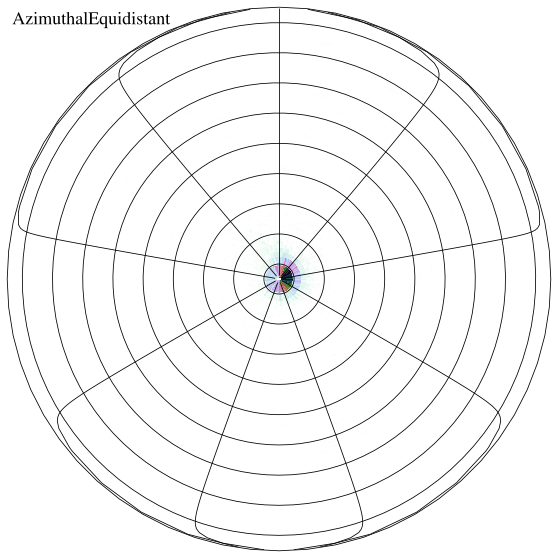

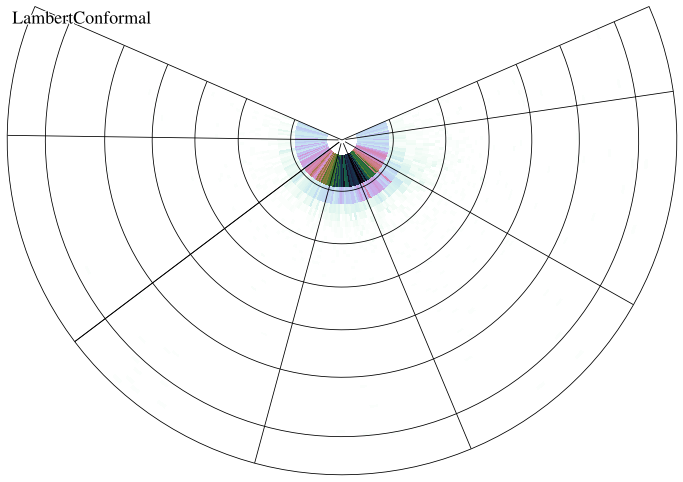

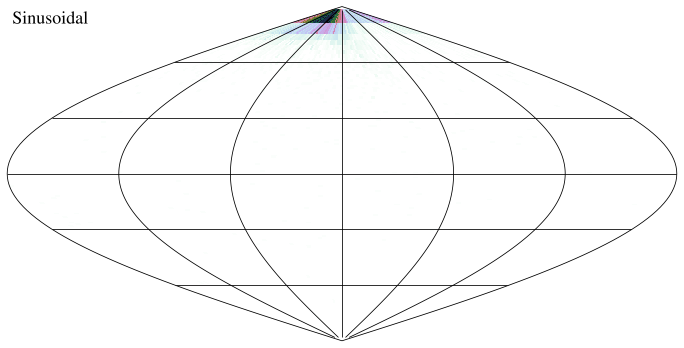

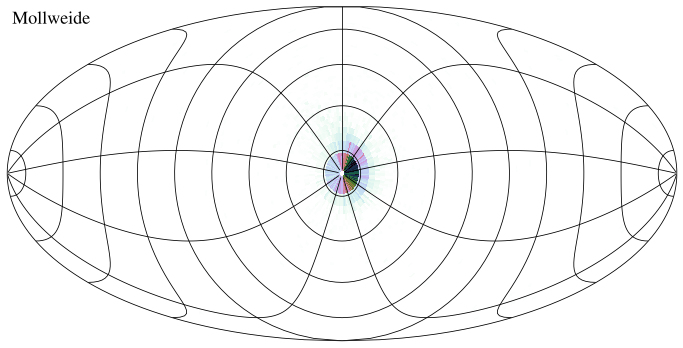

In [147]:
for proj_str, img_proj in projections:
    
    fig = plt.figure( figsize=(12,10), )

    proj = getattr( ccrs, proj_str )()
    ax = plt.axes( projection=proj )

    n_bins = 128
    ra_edges = np.linspace( -np.pi, np.pi, n_bins )
    dec_edges = np.linspace( -np.pi/2., np.pi/2., n_bins )
    cosdec_edges = np.linspace( -1, 1, n_bins )

    hist2d, ra_edges, da_edges = np.histogram2d(
        phi,
        np.cos( theta ),
        bins = [ ra_edges, cosdec_edges ],
    )
    ra_centers = 0.5 * ( ra_edges[1:] + ra_edges[:-1] ) * 180. / np.pi
    dec_edges = np.pi / 2. - np.arccos( cosdec_edges )
    dec_edges *= 180. / np.pi
    dec_centers = 0.5 * ( dec_edges[1:] + dec_edges[:-1] )

    ax.pcolormesh(
        ra_centers,
        dec_centers,
        hist2d.transpose(),
        transform = img_proj,
        cmap = matplotlib.cm.cubehelix_r,
        shading = 'nearest',
    )
    
    ax.gridlines( crs=img_proj, color='k' )
    
    text = ax.annotate(
        text = proj_str,
        xy = ( 0, 1 ),
        xytext = ( 5, -5 ),
        xycoords = 'axes fraction',
        textcoords = 'offset points',
        ha = 'left',
        va = 'top',
        fontsize = 18,
    )
    text.set_path_effects([
        path_effects.Stroke(linewidth=2.5, foreground='w'),
        path_effects.Normal()
    ])